In [2]:
# Utilize only 50% of GPU

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config= ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction= 0.5
config.gpu_options.allow_growth= True
session= InteractiveSession(config= config)

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:09<00:00, 209MB/s]
100% 1.06G/1.06G [00:09<00:00, 126MB/s]


In [6]:
import zipfile
zip_ref= zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
# CNN

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Preprocessing

train_datagen= ImageDataGenerator(rescale= 1./255,
                                  shear_range= 0.2,
                                  zoom_range= 0.2,
                                  horizontal_flip= True)

In [9]:
training_set= train_datagen.flow_from_directory('/content/train',
                                                target_size= (64, 64),
                                                batch_size= 32,
                                                class_mode= 'binary')

test_datagen= ImageDataGenerator(rescale= 1./255)
test_set= test_datagen.flow_from_directory('/content/test',
                                           target_size= (64, 64),
                                           batch_size= 32,
                                           class_mode= 'binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [12]:
from tensorflow.keras.regularizers import l2

In [18]:
# Building CNN

cnn= tf.keras.models.Sequential()

# Convolution
cnn.add(tf.keras.layers.Conv2D(filters= 32, padding= 'same', kernel_size= 3, activation= 'relu', strides= 2, input_shape= [64, 64,3]))

# Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2))

# Second Convolution
cnn.add(tf.keras.layers.Conv2D(filters= 32, padding= 'same', kernel_size= 3, activation= 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2))

# Flatten
cnn.add(tf.keras.layers.Flatten())

# Dense layer
cnn.add(tf.keras.layers.Dense(units= 128, activation= 'relu'))

# Output layer (SVM)
cnn.add(Dense(1, kernel_regularizer= tf.keras.regularizers.l2(0.01), activation= 'linear'))

cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [19]:
# Training

cnn.compile(optimizer= 'adam', loss= 'hinge', metrics= ['accuracy'])

r= cnn.fit(x= training_set, validation_data= test_set, epochs= 15)

Epoch 1/15
625/625 [==============================] - 91s 143ms/step - loss: 0.8022 - accuracy: 0.6184 - val_loss: 0.7298 - val_accuracy: 0.7260
Epoch 2/15
625/625 [==============================] - 87s 139ms/step - loss: 0.6346 - accuracy: 0.7050 - val_loss: 0.6001 - val_accuracy: 0.7126
Epoch 3/15
625/625 [==============================] - 89s 143ms/step - loss: 0.5890 - accuracy: 0.7237 - val_loss: 0.5573 - val_accuracy: 0.7248
Epoch 4/15
625/625 [==============================] - 87s 139ms/step - loss: 0.5530 - accuracy: 0.7416 - val_loss: 0.5031 - val_accuracy: 0.7772
Epoch 5/15
625/625 [==============================] - 88s 140ms/step - loss: 0.5283 - accuracy: 0.7521 - val_loss: 0.5108 - val_accuracy: 0.7926
Epoch 6/15
625/625 [==============================] - 87s 140ms/step - loss: 0.5133 - accuracy: 0.7622 - val_loss: 0.4768 - val_accuracy: 0.7928
Epoch 7/15
625/625 [==============================] - 85s 136ms/step - loss: 0.4961 - accuracy: 0.7713 - val_loss: 0.4580 - val_ac

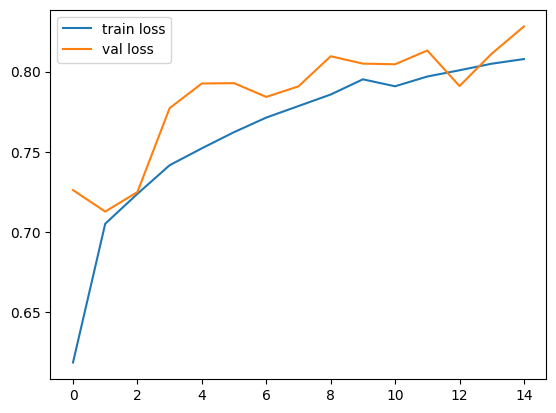

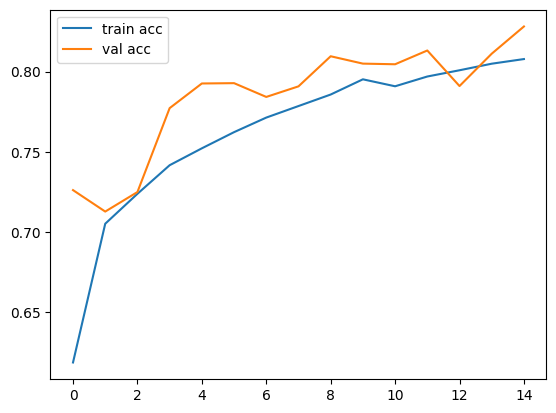

In [22]:
# Plotting

import matplotlib.pyplot as plt

plt.plot(r.history['accuracy'], label= 'train loss')
plt.plot(r.history['val_accuracy'], label= 'val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label= 'train acc')
plt.plot(r.history['val_accuracy'], label= 'val acc')
plt.legend()
plt.show()

In [24]:
from tensorflow.keras.models import load_model

cnn.save('model_catvdog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
# Prediction

import numpy as np

from tensorflow.keras.preprocessing import image
test_img= image.load_img('/content/test/dogs/dog.100.jpg', target_size= (64,64))
test_img= image.img_to_array(test_img)
test_img= test_img/255
test_img= np.expand_dims(test_img, axis= 0)
result= cnn.predict(test_img)

1/1 [==============================] - 0s 271ms/step


In [30]:
result

array([[1.3686655]], dtype=float32)

In [32]:
if result[0]>0:
  print('The image is of a dog')

else:
  print('The image is of a cat')

The image is of a dog
